# PyKX Sub-Process Statistics
Use an external q process to connect to a managed kdb cluster and measure communication latency.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import subprocess
import boto3
import json
import datetime

import pykx as kx
import matplotlib.pyplot as plt

from managed_kx import *
from env import *

# Cluster names and database
from basictick_setup import *

# ----------------------------------------------------------------
CODEBASE="basictick"

KILL_SUBSCRIBER = False
# ----------------------------------------------------------------


In [2]:
# triggers credential get
session=None

if AWS_ACCESS_KEY_ID is None:
    print("Using Defaults ...")
    # create AWS session: using access variables
    session = boto3.Session()
else:
    print("Using variables ...")
    session = boto3.Session(
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        aws_session_token=AWS_SESSION_TOKEN
    )

# create finspace client
client = session.client(service_name='finspace', endpoint_url=ENDPOINT_URL)

Using Defaults ...


# Start q process that subscribes to RTS
This notebook will record the measured latency in communications between this created q process and the RTS cluster.

## Configuration
Environment variable QHOME is set to where q is locally to this notebook.


In [3]:
# get the connection string
conn_str = get_kx_connection_string(client, environmentId=ENV_ID, clusterName=RTS_CLUSTER_NAME, userName=KDB_USERNAME, boto_session=session)

subscriber_mode = "trade_last" 
#subscriber_mode = "trade_vwap" 
#subscriber_mode = "trade_hlcv" 

# Is process already running?
create = True

try:
    # Will connect if running
    with kx.QConnection(port=SUBSCRIBER_PORT) as q:
        create=False 
        print(f"Running on port: {SUBSCRIBER_PORT}")
except RuntimeError:
    pass
except:
    pass

if create:    
    try:
        # start q process kxtaqsubscriber to connect to the TP at $TP_CONN
        if os.getenv('QHOME') is not None:
            subprocess.Popen(f'cd {CODEBASE}; nohup $QHOME/l64/q kxtaqsubscriber.q -p {SUBSCRIBER_PORT} -endpoint "{conn_str}" -mode {subscriber_mode}', shell=True)
            print(f"Started on port: {SUBSCRIBER_PORT}")
        else:
            print("Environment variable QHOME is not set, please set to where kdb is installed")
    except:
        pass

    # wait for RTS subscriber to start collecting data
    time.sleep(10)
    

Running on port: 5040


In [4]:
%%q 
profile:hopen`::5040
percentile:{(asc x) floor y*count x}

results:{
        select 
                 counter:count i, 
                 min_latency:min source_to_consumer_latency, 
                 max_latency:max source_to_consumer_latency, 
                 latency_p50:percentile[source_to_consumer_latency;.50], 
                 latency_p90:percentile[source_to_consumer_latency;.90], 
                 latency_p99:percentile[source_to_consumer_latency;.99], 
                 avg_source_to_calc_latency:"n"$avg source_to_calc_latency, 
                 avg_source_to_consumer_latency:"n"$avg source_to_consumer_latency 
         from profile".perf.stats"
 }

In [5]:
display( kx.q('results[]').pd() )

,counter,min_latency,max_latency,latency_p50,latency_p90,latency_p99,avg_source_to_calc_latency,avg_source_to_consumer_latency
0,705,0 days 00:00:00.006392230,0 days 00:00:00.007097279,0 days 00:00:00.006562169,0 days 00:00:00.006733066,0 days 00:00:00.007097279,0 days 00:00:00.005933298,0 days 00:00:00.006574864


In [6]:
def plot_time_vs_timedelta(dataframe, x_column, y_column):
  # Convert timedelta to seconds for plotting
    dataframe['y_seconds'] = dataframe[y_column].dt.total_seconds()

    plt.figure(figsize=(10,6))
    # Plot
    plt.plot(dataframe[x_column], dataframe['y_seconds'])
    
    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Time Delta (seconds)')
    plt.title('Time vs Time Delta')

    # Show plot
    plt.show()

,counter,min_latency,max_latency,latency_p50,latency_p90,latency_p99,avg_source_to_calc_latency,avg_source_to_consumer_latency
0,705,0 days 00:00:00.006392230,0 days 00:00:00.007097279,0 days 00:00:00.006562169,0 days 00:00:00.006733066,0 days 00:00:00.007097279,0 days 00:00:00.005933298,0 days 00:00:00.006574864


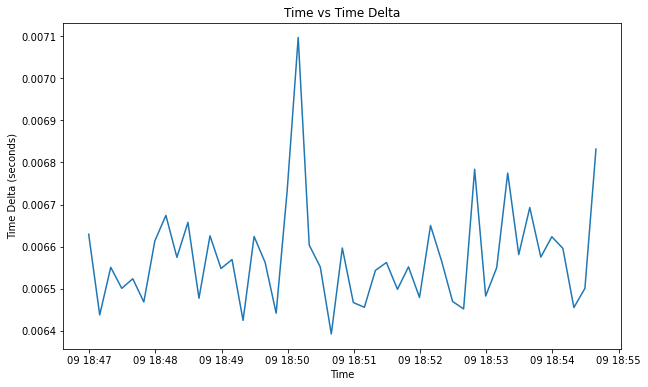

In [7]:
# get current results
results = kx.q('results[]').pd() 

# if not 200 collected, wait for more (makes for a better graph)
if results['counter'][0] < 200:
    time.sleep(20)
    results = kx.q('results[]').pd() 

display( results )

# get raw stats and display as table
stats = kx.q('profile".perf.stats"').pd()

# Plot the stats
plot_time_vs_timedelta(stats,'receiveTime','source_to_consumer_latency')

# Cleanup

Connect to the running process created above and have it exit.
```
$ q
q) h:hopen`::5040
q) @[h; "exit 0", {}]
```

KILL_SUBSCRIBER must be True for the process to be killed.

In [8]:
#KILL_SUBSCRIBER=True

if KILL_SUBSCRIBER:
    try:
        with kx.QConnection(port=SUBSCRIBER_PORT) as q:
            q("exit 0") 
    except RuntimeError:
        print("Stopped")
else:
    print("Subscriber not killed")

Subscriber not killed


In [9]:
print( f"Last Run: {datetime.datetime.now()}" )

Last Run: 2024-08-09 18:54:42.711593
